In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skewnorm
import networkx as nx
from typing import Callable

*  Косое нормальное распределение с параметром по умолчанию skew_alpha = 1
*  Распределение Лапласа с параметрами по умолчанию laplace_alpha = 0, laplace_beta = $\sqrt{\frac{1}{2}}$


In [4]:
skew_alpha = 1
laplace_alpha = 0
laplace_beta = 1 / np.sqrt(2)

In [15]:
def gen_skewnormal_points(num_points: int, alpha: float = skew_alpha) -> np.ndarray[np.float64]:
    """ Возвращает num_points точек сгенерированных по косому нормальному распределению S(alpha) """
    return skewnorm.rvs(alpha, size=num_points)

In [16]:
def gen_laplace_points(num_points: int, alpha: float = laplace_alpha, beta : float = laplace_beta) -> np.ndarray[np.float64]:
    """ Возвращает num_points точек сгенерированных по распределению Лапласа L(alpha, beta) """
    return np.random.laplace(loc=alpha, scale=beta, size=num_points)

In [20]:
class Graph:
    def __init__(self, points: np.ndarray[float], edges: set[tuple[int, int]] = set()) -> None:
        self.V = points
        self.E = [sorted(edge) for edge in edges]
        self.nx_obj = nx.empty_graph(len(points))
        self.nx_obj.add_edges_from(edges)


    def build_KNN_graph(self, K: int) -> None:
        """ Строит ребра KNN графа """
        self.E = set()

        for idx_1, x_1 in enumerate(self.V):
            dist = []
            for idx_2, x_2 in enumerate(self.V):
                dist.append([np.linalg.norm(x_1 - x_2), idx_2])
            for nearest in sorted(dist)[1:K+1]:
                self.E.add( (min(idx_1, nearest[1]), max(idx_1, nearest[1])) )

        self.nx_obj.clear_edges()
        self.nx_obj.add_edges_from(self.E)

    def build_dist_graph(self, max_dist: int) -> None:
        """ Строит ребра Distance графа """
        self.E = set()

        for idx_1, x_1 in enumerate(self.V):
            dist = []
            for idx_2, x_2 in enumerate(self.V):
                if (idx_2 <= idx_1):
                    continue
                if np.linalg.norm(x_1 - x_2) <= max_dist:
                    self.E.add( (idx_1, idx_2) )

        self.nx_obj.clear_edges()
        self.nx_obj.add_edges_from(self.E)

    def draw(self) -> None:
        """ Рисует граф """
        if (len(self.V) == 0):
            print("Пустой граф.")
            return

        for e in self.E:
            x1, y1 = self.V[e[0]], e[0]
            x2, y2 = self.V[e[1]], e[1]
            plt.plot([x1, x2], [y1, y2], 'b-', linewidth=1)
        plt.scatter(self.V, range(len(self.V)), color="blue")
        plt.title("Наш граф")
        plt.xlabel("Ее координата")
        plt.ylabel("Номер вершины")

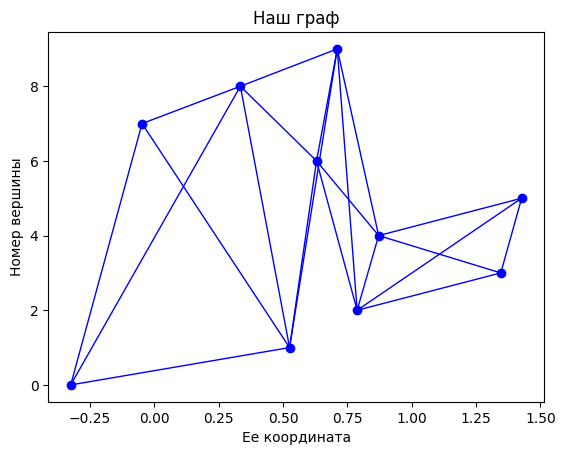

In [28]:
knn_skew_normal = Graph(points = gen_skewnormal_points(10))
knn_skew_normal.build_KNN_graph(K = 3)
knn_skew_normal.draw()

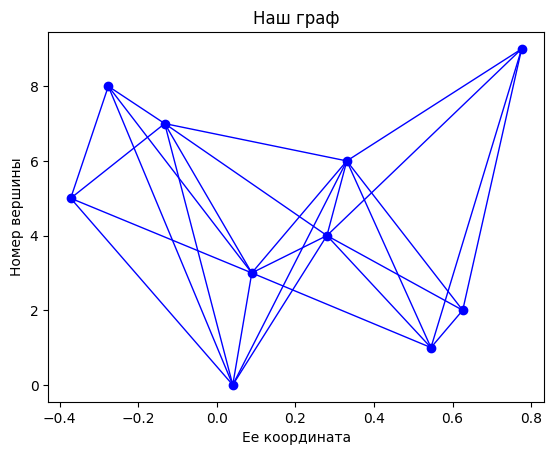

In [27]:
dist_laplace = Graph(points = gen_laplace_points(10))
dist_laplace.build_dist_graph(max_dist = 0.5)
dist_laplace.draw()

In [29]:
def calculate_min_deg(G: Graph) -> int:
    """ Возвращает минимальную степень вершин графа """
    min_degree_node, min_degree = min(G.nx_obj.degree(), key=lambda x: x[1])
    return min_degree


def calculate_max_deg(G: Graph) -> int:
    """ Возвращает максимальную степень вершин графа """
    max_degree_node, max_degree = max(G.nx_obj.degree(), key=lambda x: x[1])
    return max_degree


def calculate_number_component(G: Graph) -> int:
    """ Возвращает число компонент связности графа """
    return nx.number_connected_components(G.nx_obj)


def calculate_number_articul(G: Graph) -> int:
    """ Возвращает число точек сочленения графа """
    return len(list(nx.articulation_points(G.nx_obj)))


def calculate_number_triangle(G: Graph) -> int:
    """ Возвращает число триугольников графа """
    triangles_dict =  nx.triangles(G.nx_obj)
    return sum(triangles_dict.values()) // 3


def calculate_clique_number(G: Graph) -> int:
    """ Возвращает кликовое число графа """
    max_cliques = list(nx.find_cliques(G.nx_obj))
    return max([len(clique) for clique in max_cliques])

def calculate_maxsize_independed_set(G: Graph) -> int:
    """ Возвращает размер максимального независимого множества """
    V_compl = G.V
    E_compl = set()
    for i in range(len(G.V)):
        for j in range(i + 1, len(G.V)):
            if [i, j] not in G.E:
                E_compl.add((i, j))
    G_compl = Graph(V_compl, E_compl)
    return calculate_clique_number(G_compl)

In [30]:
human_readable_characts = {"calculate_min_deg": "Минимальная степень вершины",
                           "calculate_max_deg": "Максимальная степень вершины",
                           "calculate_number_component": "Количество компонент связности",
                           "calculate_number_articul": "Количество точек сочленения",
                           "calculate_number_triangle": "Количество треугольников",
                           "calculate_clique_number": "Кликовое число",
                           "calculate_maxsize_independed_set": "Размер наибольшего независимого множества" }

In [46]:
def evaluate(
        num_samples: int = 420,                                          # количество реализация характеристики
        vector_size: int = 42,                                           # размерность случайного вектора
        skew_alpha: float = skew_alpha,                                  # параметр alpha косого нормального распределение
        laplace_alpha: float = laplace_alpha,                            # параметр alpha распределения Лапласа
        laplace_beta: float = laplace_beta,                              # параметр beta распределения Лапласа
        T_knn_foo: Callable[[Graph], int] = calculate_number_component,  # функция вычисления характеристики для KNN графа
        knn_num_neighbours: int = 42,                                    # количество соседей KNN графа
        T_dist_foo: Callable[[Graph], int] = calculate_clique_number,    # функция вычисления характеристики для Distance графа
        dist_max_dist: int = 4.2,                                        # макисмальная длина соединения Distance графа
        verbose : bool = False                                           # рисовать ли гистограммы распределения
) -> dict[str: list]:
    """
    Несколько раз симмулирует реализацию случайного вектора с некоторыми параметрами.
    Строит по ним KNN и Distance графы с некоторыми параметрами процедуры построения,
    вычисляет на них характеристики и визуализирует их распределение.
    Возвращает списки получившихся характеристик.
    """
    T_knn_skew_normal_list, T_knn_laplace_list = [], []
    T_dist_skew_normal_list, T_dist_laplace_list = [], []

    for i in range(num_samples):
        skew_normal_sample = gen_skewnormal_points(vector_size, skew_alpha)
        laplce_sample = gen_laplace_points(vector_size, laplace_alpha, laplace_beta)

        G_knn_skew_normal = Graph(points = skew_normal_sample)
        G_knn_skew_normal.build_KNN_graph(K = knn_num_neighbours)
        T_knn_skew_normal_list.append(T_knn_foo(G = G_knn_skew_normal))

        G_knn_laplace = Graph(points = laplce_sample)
        G_knn_laplace.build_KNN_graph(K = knn_num_neighbours)
        T_knn_laplace_list.append(T_knn_foo(G = G_knn_laplace))

        G_dist_skew_normal = Graph(points = skew_normal_sample)
        G_dist_skew_normal.build_dist_graph(max_dist = dist_max_dist)
        T_dist_skew_normal_list.append(T_dist_foo(G = G_dist_skew_normal))

        G_dist_laplace = Graph(points = laplce_sample)
        G_dist_laplace.build_dist_graph(max_dist = dist_max_dist)
        T_dist_laplace_list.append(T_dist_foo(G = G_dist_laplace))

    if verbose:
        plt.figure(figsize=(16, 3))


        plt.subplot(1, 2, 1)
        plt.title(f"Распределение характеристики \'{human_readable_characts[T_knn_foo.__name__]}\' \nKNN граф.       " +
                  f"K={knn_num_neighbours} \n\nLaplace( {laplace_alpha},  {laplace_beta} ) \nSkewnormal({skew_alpha} )")
        bins = np.arange(min(T_knn_skew_normal_list + T_knn_laplace_list), max(T_knn_skew_normal_list + T_knn_laplace_list) + 1, 1)
        plt.hist(T_knn_skew_normal_list, bins=bins, align="mid", alpha = 0.5, label="Косое нормальное распределение")
        plt.hist(T_knn_laplace_list, bins=bins, align="mid", alpha = 0.5, label="Распределение Лапласа")
        plt.xticks(bins)
        plt.xlabel("Значение характеристики")
        plt.ylabel("Количество графов")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title(f"Распределение характеристики \'{human_readable_characts[T_dist_foo.__name__]}\' \nDistance граф.       " +
                  f"max_distance_connected={dist_max_dist} \n\nLaplace( {laplace_alpha},  {laplace_beta} ) \nSkewnormal({skew_alpha} )")
        bins = np.arange(min(T_dist_skew_normal_list + T_dist_laplace_list), max(T_dist_skew_normal_list + T_dist_laplace_list) + 1, 1)
        plt.hist(T_dist_skew_normal_list, bins=bins, align="mid", alpha = 0.5, label="Косое нормальное распределение")
        plt.hist(T_dist_laplace_list, bins=bins, align="mid", alpha = 0.5, label="Распределение Лапласа")
        plt.xticks(bins)
        plt.xlabel("Значение характеристики")
        plt.ylabel("Количество графов")
        plt.legend()

        plt.show()
        print()

    return { "T_knn_skew_normal_list": T_knn_skew_normal_list,
             "T_knn_laplace_list": T_knn_laplace_list,
             "T_dist_skew_normal_list": T_dist_skew_normal_list,
             "T_dist_laplace_list": T_dist_laplace_list }

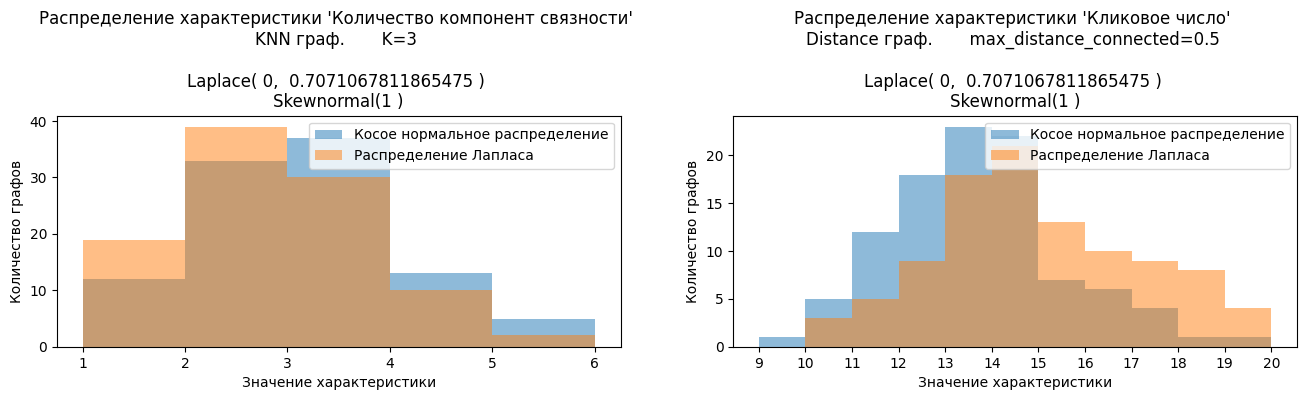


Графики


In [49]:
evaluate(num_samples=100, vector_size=40, verbose=True, knn_num_neighbours = 3, dist_max_dist = 0.5)
print("Графики")